<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Columns: 101 entries, timestamp to cons_99
dtypes: float64(100), object(1)
memory usage: 1.7+ MB
             timestamp  cons_0  cons_1  cons_2  cons_3  cons_4  cons_5  \
0  2018-01-01 00:00:00   0.290   0.077   0.206   0.160   0.353   0.263   
1  2018-01-01 01:00:00   0.350   0.059   0.248   0.284   0.710   0.363   
2  2018-01-01 02:00:00   0.229   0.400   0.136   0.283   0.329   0.339   
3  2018-01-01 03:00:00   0.207   0.100   0.124   0.391   0.283   0.357   
4  2018-01-01 04:00:00   0.186   0.064   0.084   0.394   0.169   0.300   

   cons_6  cons_7  cons_8  ...  cons_90  cons_91  cons_92  cons_93  cons_94  \
0   0.104   0.265   0.032  ...    0.261    0.355    0.417    0.359    0.277   
1   0.143   0.246   0.068  ...    0.335    0.465    0.506    0.374    0.214   
2   0.203   0.110   0.054  ...    0.242    0.480    1.376    0.398    0.244   
3   0.081   0.115   0.059  ...    0.191    0.477    0.224    0.330  

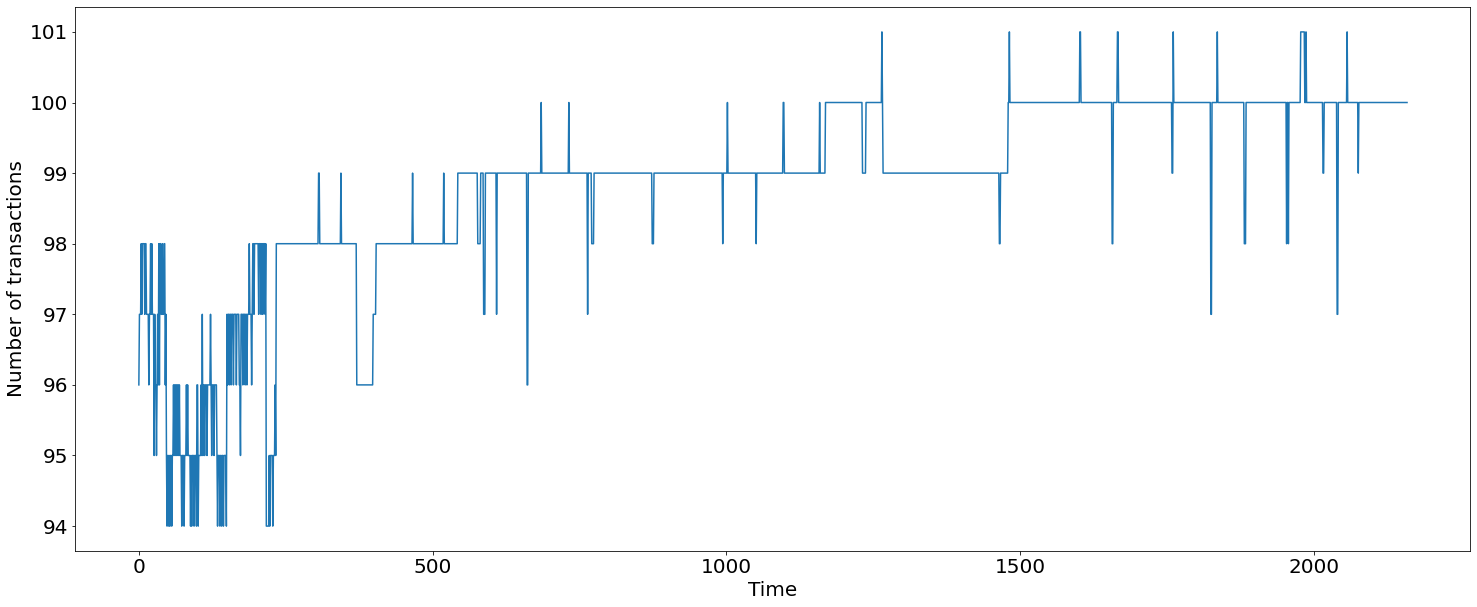

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data=pd.read_csv("Desktop/smartmeters_dataset.csv")
data.info()
print(data.head(5))
data["number_of_transactions"]=data.astype(bool).sum(axis=1)
data["time"]=range(0,2160)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.figure(figsize=(25, 10))
plt.plot(data["time"],data["number_of_transactions"])
plt.xlabel('Time')
plt.ylabel('Number of transactions')
print(data["number_of_transactions"].describe())

In [7]:
import numpy as np
import matplotlib.pyplot as plt 
import time
from collections import defaultdict
import threading
import networkx as nx
def def_value():
    return "There is no elements yet"


In [31]:
class DAG(object):
    def __init__(self, t_lambda=50, alpha_rate=0.001, plot=True):
   
        self.t_lambda = t_lambda
        self.alpha_rate = alpha_rate
        self.time = 1.0
        self.c_weight_logs = dict()
        self.nodes_log = set()
        self.random_walk_log = list()
        self.num_nodes = 1
        if plot:
            self.G = nx.OrderedDiGraph()
        self.gen_node = Genesis(self)
        self.nodes = [self.gen_node]

    def new_node(self):
        self.num_nodes += 1
        approved_set = set(self.markov_selection())
        self.time += np.random.poisson(1.0/self.t_lambda)
        node = Node(self, self.time, approved_set, self.num_nodes - 1)
        for n in approved_set:
            n.approved_time = np.minimum(self.time, n.approved_time)
            n._approvers.add(node)
            if hasattr(self, 'G'):
                self.G.add_edges_from([(node.id, n.id)])
        self.nodes.append(node)
        self.c_weight_logs = {}
        

    def tips(self):
        tips = [n for n in self.nodes if n.is_prepared() and n.is_delayed()]
        return tips
    
    def markov_selection(self):
        W = self.num_nodes - int(10 * self.t_lambda)
        W1 = np.maximum(0, 2 * W - self.num_nodes)
        W2 = np.maximum(1, W)
        nodes_to_walk = np.random.choice(self.nodes[W1:W2], 10)
        for n in nodes_to_walk:
            t = threading.Thread(target=self.random_walk(n))
            t.start()
        tips = self.random_walk_log[:2]
        self.random_walk_log = list()
        return tips

    def random_walk(self, start_node):
        current_node = start_node
        while current_node.is_prepared() and not current_node.is_delayed():
            if len(self.random_walk_log) >= 2:
                return
            
            next_nodes = current_node.approvers()
            if  self.alpha_rate > 0:
                current_node_c_weight = current_node.c_weight_delayed()
                c_weights = np.array([])
                for node in next_nodes:
                    c_weights = np.append(c_weights, node.c_weight_delayed())
                    nom = np.exp(-self.alpha_rate *
                             (current_node_c_weight - c_weights))
                    denom = np.sum(np.exp(-self.alpha_rate *
                                      (current_node_c_weight - c_weights)))
                    probabilities = np.divide(nom, denom)
            else:
                probabilities = None
                
            current_node = np.random.choice(next_nodes, p=probabilities)
        self.random_walk_log.append(current_node)
        
    
    def plot(self):
        if hasattr(self, 'G'):
            pos = nx.get_node_attributes(self.G, 'pos')
            nx.draw_networkx_nodes(self.G, pos)
            nx.draw_networkx_labels(self.G, pos)
            nx.draw_networkx_edges(self.G, pos, edgelist=self.G.edges(), arrows=True)
            plt.xlabel('Time')
            plt.yticks([])
            plt.show()

class Node(object):
    def __init__(self, dag, time, approved_nodes, id):
        self.dag = dag
        self.id = id
        self.time = time
        self.approved_nodes = approved_nodes
        self._approvers = set()
        self.approved_time = float("inf")
        self._approved_by = set()
    
        if hasattr(self.dag, 'G'):
            self.dag.G.add_node(self.id, pos=(self.time, np.random.uniform(-1, 1)))
        
    def is_prepared(self):
        return self.dag.time >= self.time + 1.0

    def is_tip(self):
        return self.dag.time < self.approved_time
    
    def is_delayed(self):
        return self.dag.time - 1.0 < self.approved_time
     
    def c_weight(self):
        c_weight = 1 + len(self.approved_by())
        self.dag.nodes_log = set()
        return c_weight

    def c_weight_delayed(self):
        c = self.dag.c_weight_logs.get(self.id)
        if c:
            return c
        else:
            c = 1 + len(self.approved_by_delayed())
            self.dag.nodes_log = set()
            self.dag.c_weight_logs[self.id] = c
        return c
    

    def approved_by(self):
        for n in self._approvers:
            if n not in self.dag.nodes_log:
                self.dag.nodes_log.add(n)
                self.dag.nodes_log.update(n.approved_by())
        return self.dag.nodes_log
    
    def approved_by_delayed(self):
        for n in self.approvers():
            if n not in self.dag.nodes_log:
                self.dag.nodes_log.add(n)
                self.dag.nodes_log.update(n.approved_by_delayed())
        return self.dag.nodes_log
    
    def approvers(self):
        return [n for n in self._approvers if n.is_prepared()]

    def __repr__(self):
        return '<Node {}'.format(self.id)


class Genesis(Node):
    
    def __init__(self, dag):
        self.dag = dag
        self.time = 0
        self.approved_nodes = []
        self.approved_time = float('inf')
        self._approvers = set()
        self.id = 0
        if hasattr(self.dag, 'G'):
            self.dag.G.add_node(self.id, pos=(0, 0))

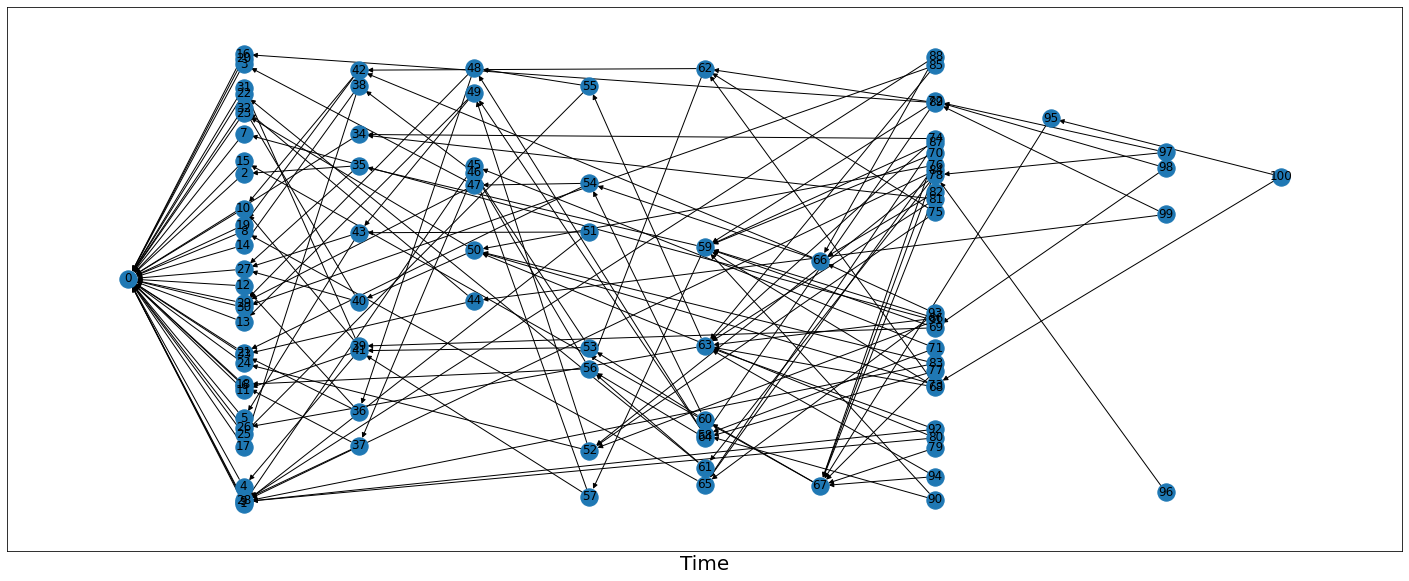

In [32]:
import time
import numpy as np
import matplotlib.pyplot as plt


plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.figure(figsize=(25, 10))
d = DAG(t_lambda=10, alpha_rate = 0.0001, plot=True)
for i in range(100):
    d.new_node()
d.plot()        


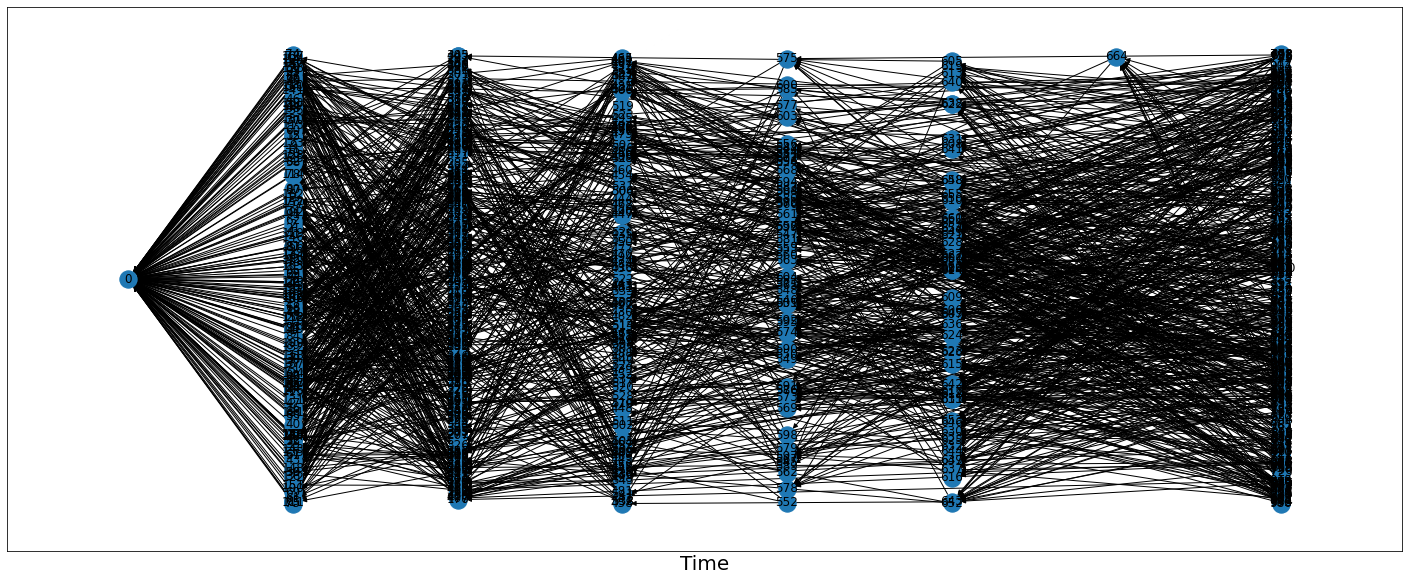

In [33]:
d = DAG(t_lambda=100, alpha_rate = 0.0001, plot=True)
plt.figure(figsize=(25, 10))
tip_count = []

for i in range(1000):
    d.new_node()
    tip_count.append([d.time, len(d.tips())])
d.plot()

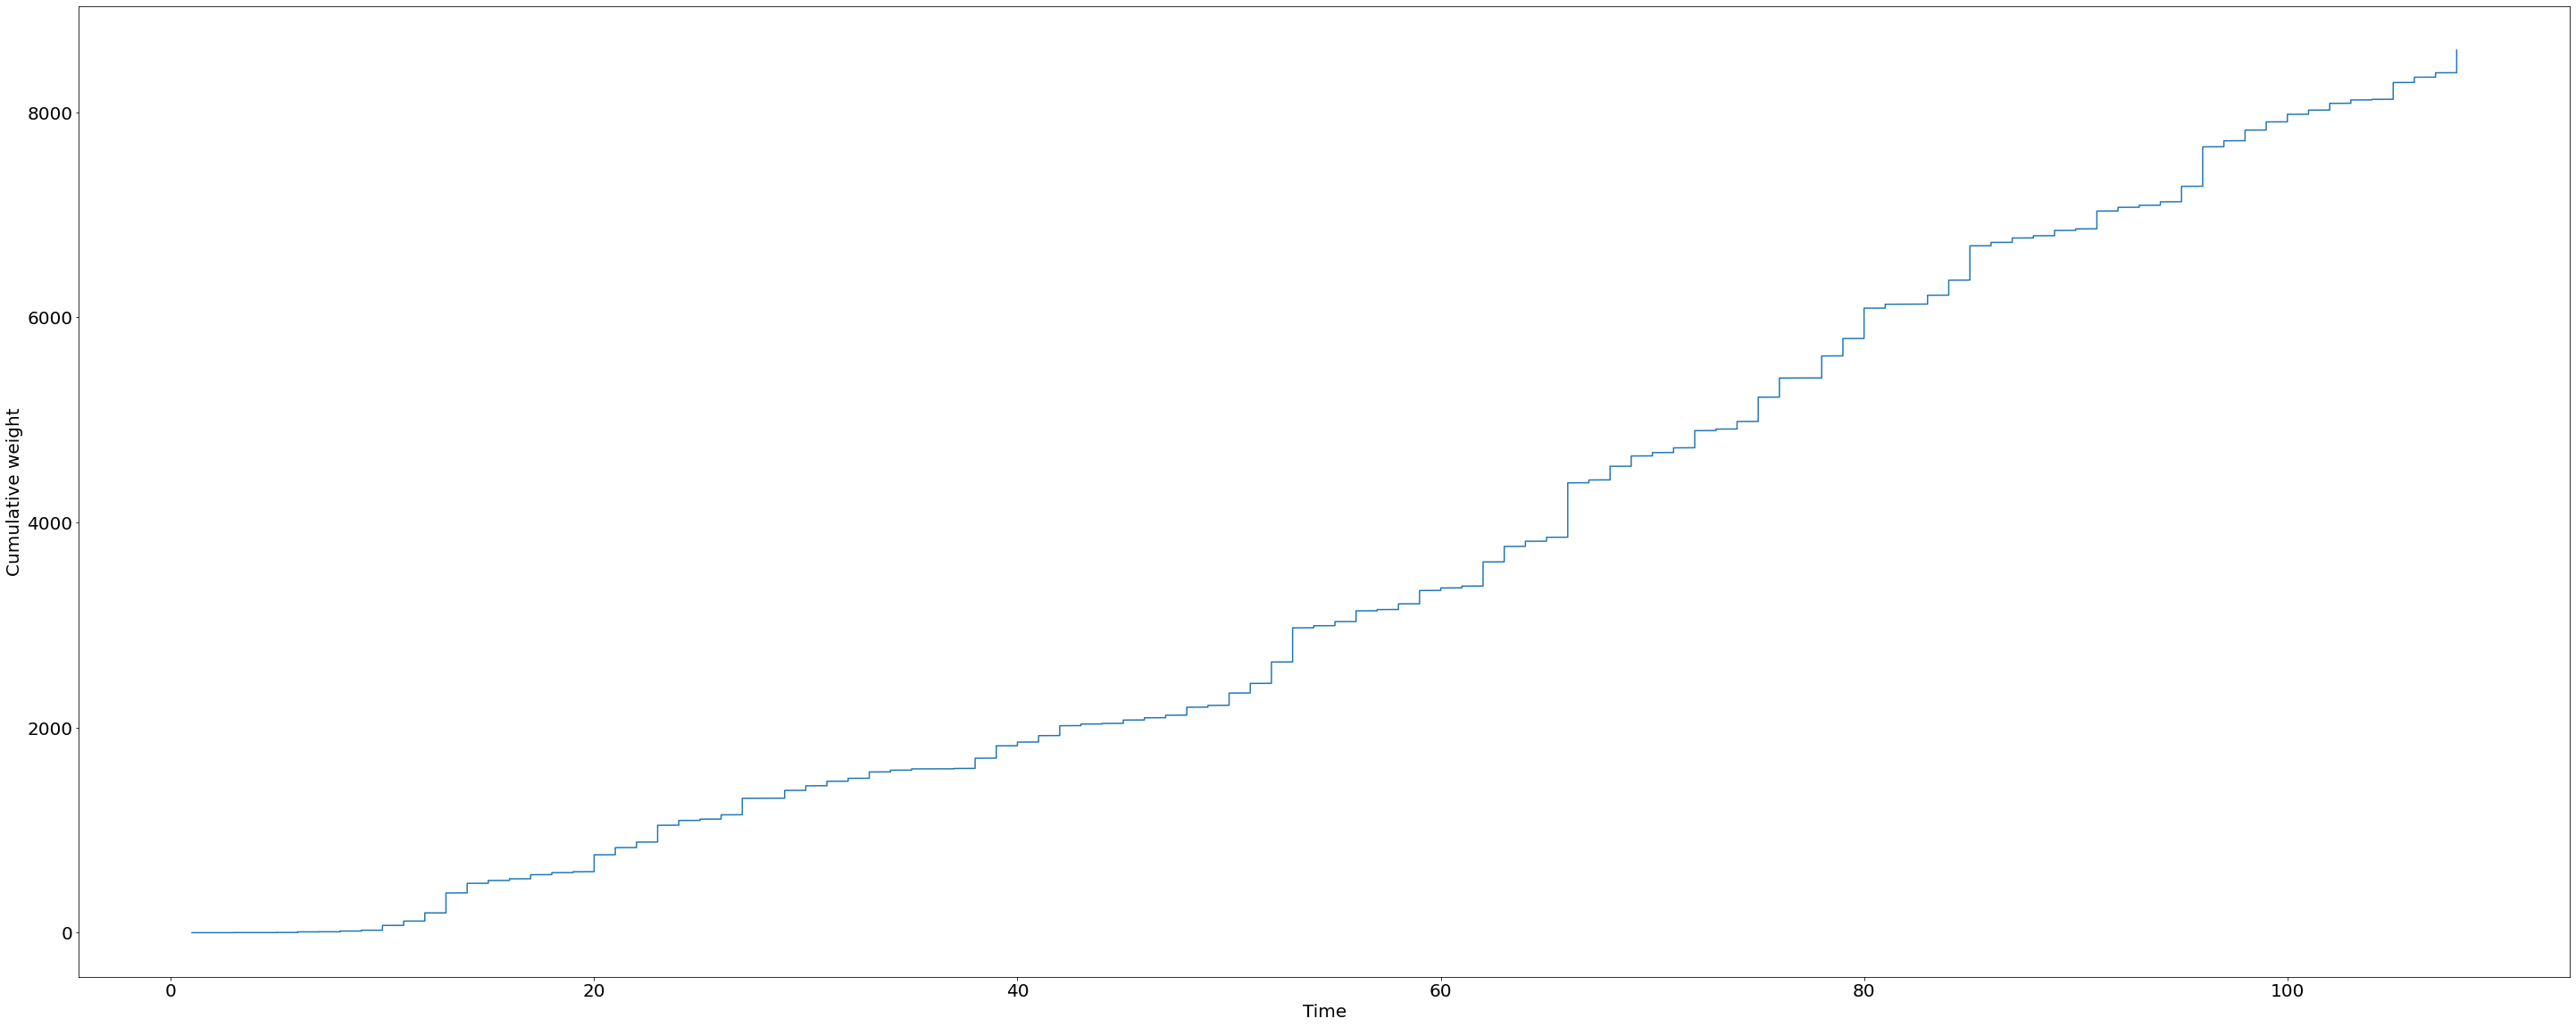

In [34]:
plt.figure(figsize=(50, 20))
d = DAG(t_lambda=100, alpha_rate=0.0001)

weight_100 = []

for i in range(10000):
    d.new_node()

    if i > 100:
        weight_100.append([d.time, d.nodes[100].c_weight()])
    else:
        weight_100.append([d.time, 0])
        
weight_100 = np.array(weight_100)
plt.plot(weight_100[:, 0], weight_100[:, 1])
plt.xlabel('Time')
plt.ylabel('Cumulative weight')
plt.show()

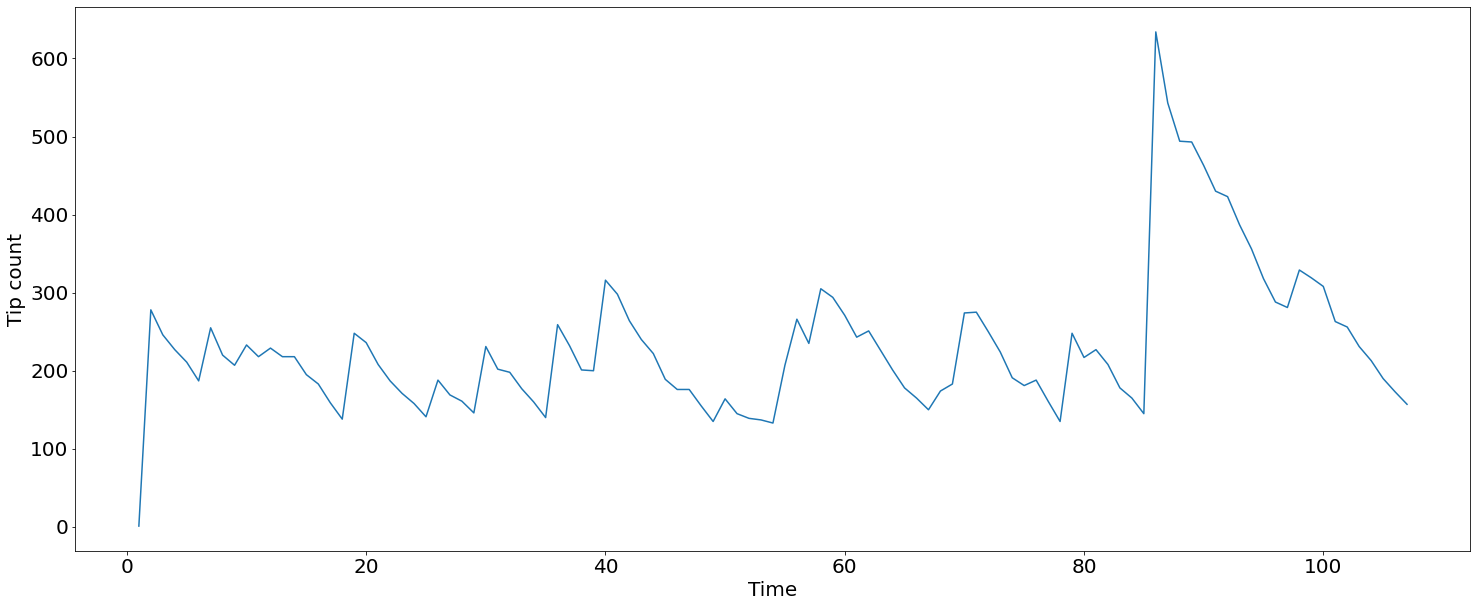

134.0437


In [35]:
plt.figure(figsize=(25, 10))
d = DAG(t_lambda=100, alpha_rate=0)

tip_count = []

for i in range(10000):
    d.new_node()
    tip_count.append([d.time, len(d.tips())])
        
tip_count = np.array(tip_count)
plt.plot(tip_count[:, 0], tip_count[:, 1])
plt.xlabel('Time')
plt.ylabel('Tip count')
plt.show()
print(np.mean(tip_count))

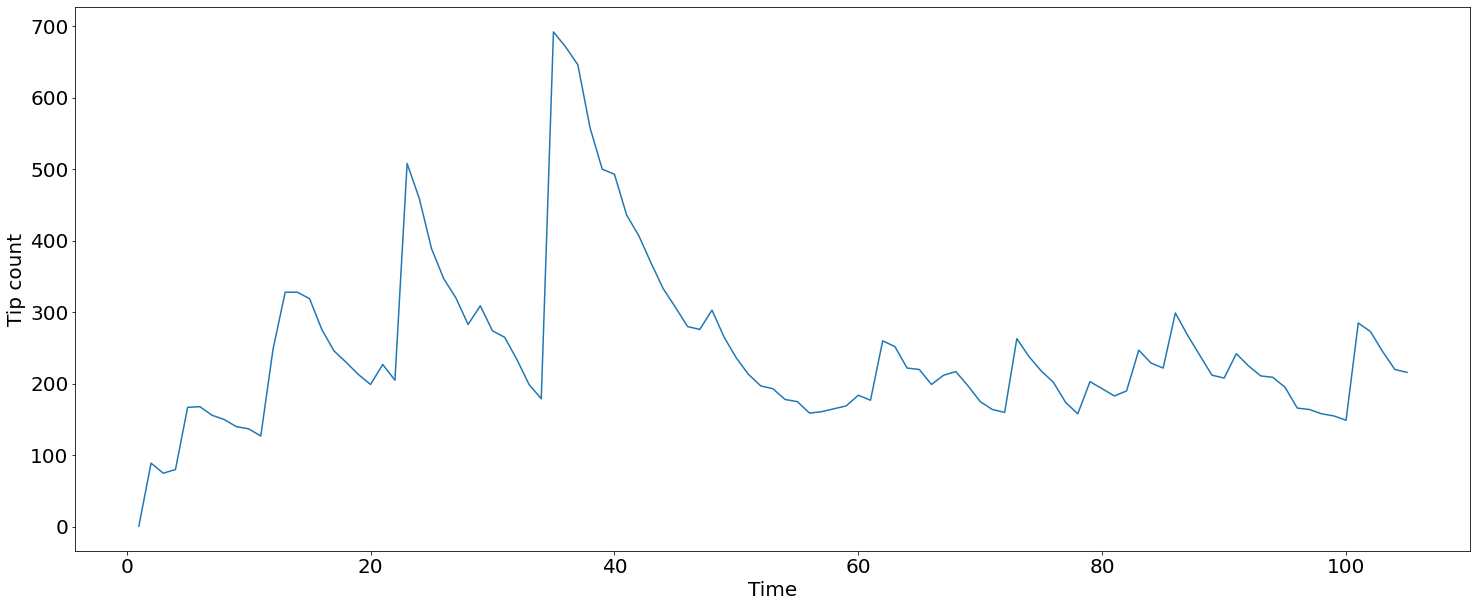

145.3628


In [36]:
plt.figure(figsize=(25, 10))
d = DAG(t_lambda=100, alpha_rate=0.01)

tip_count = []

for i in range(10000):
    d.new_node()
    tip_count.append([d.time, len(d.tips())])
        
tip_count = np.array(tip_count)
plt.plot(tip_count[:, 0], tip_count[:, 1])
plt.xlabel('Time')
plt.ylabel('Tip count')
plt.show()
print(np.mean(tip_count))

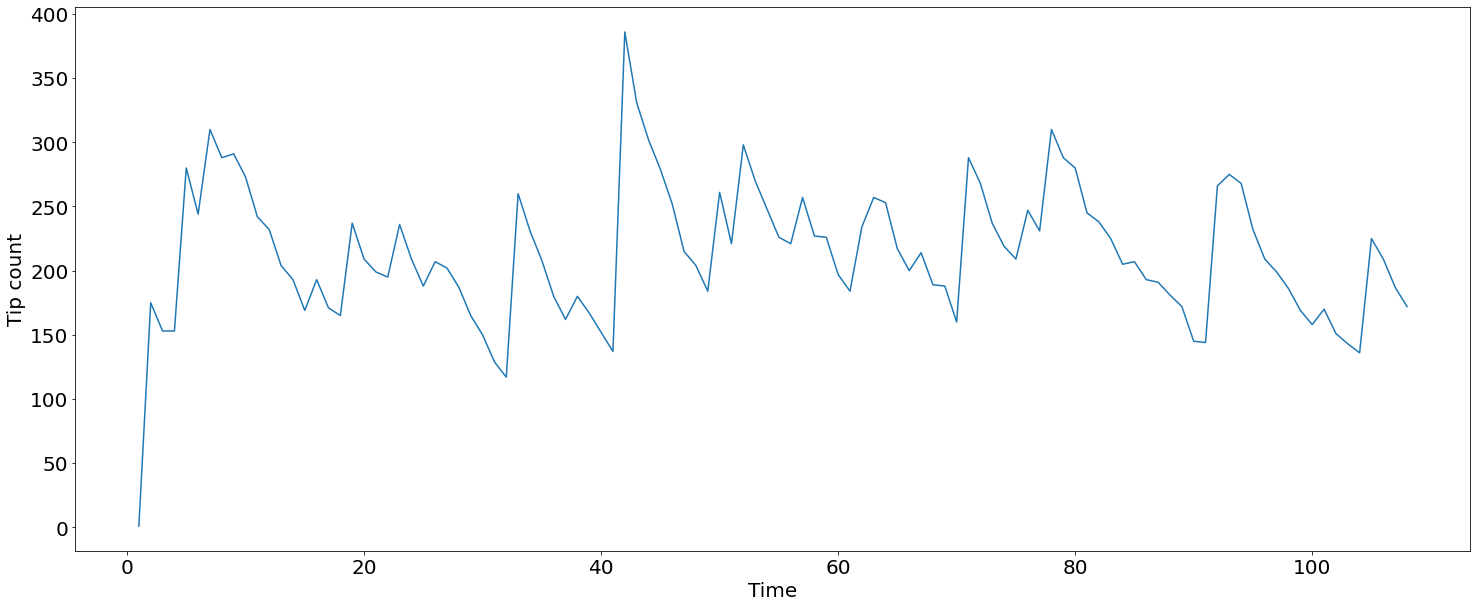

127.36545


In [37]:
plt.figure(figsize=(25, 10))
d = DAG(t_lambda=100, alpha_rate=0.001)

tip_count = []

for i in range(10000):
    d.new_node()
    tip_count.append([d.time, len(d.tips())])
        
tip_count = np.array(tip_count)
plt.plot(tip_count[:, 0], tip_count[:, 1])
plt.xlabel('Time')
plt.ylabel('Tip count')
plt.show()
print(np.mean(tip_count))

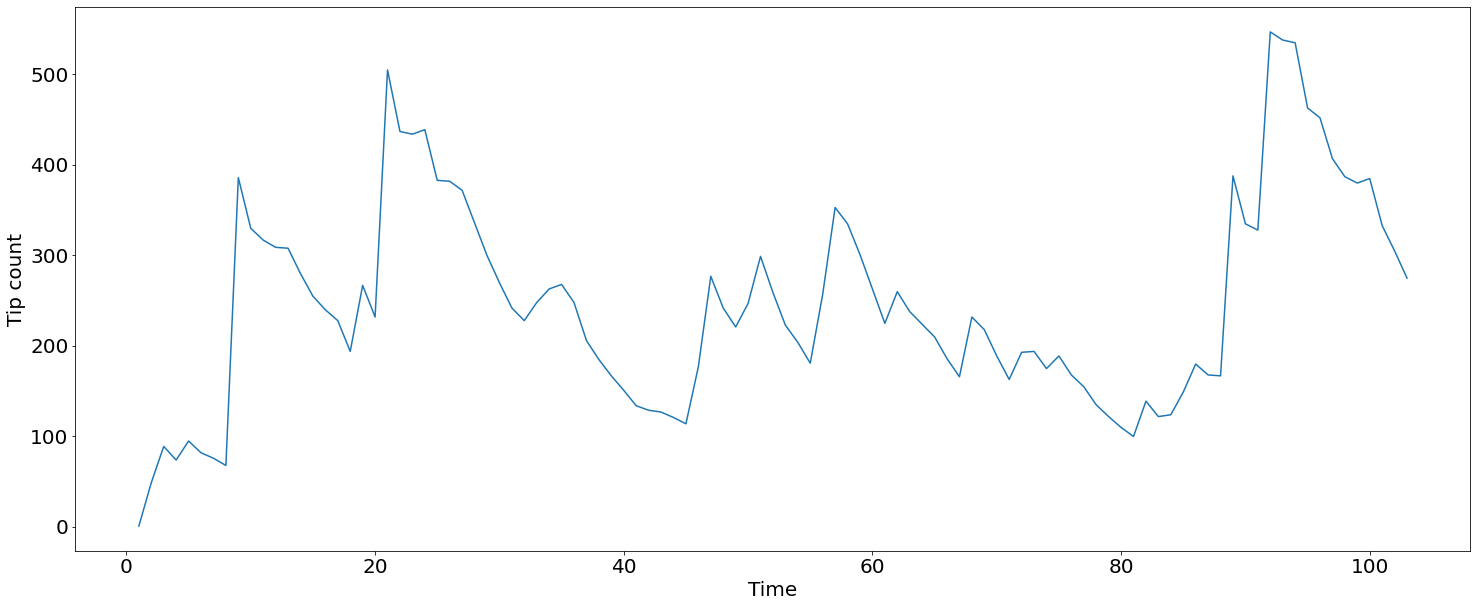

148.20345


In [38]:
plt.figure(figsize=(25, 10))
d = DAG(t_lambda=100, alpha_rate=0.0001)

tip_count = []

for i in range(10000):
    d.new_node()
    tip_count.append([d.time, len(d.tips())])
        
tip_count = np.array(tip_count)
plt.plot(tip_count[:, 0], tip_count[:, 1])
plt.xlabel('Time')
plt.ylabel('Tip count')
plt.show()
print(np.mean(tip_count))